In [62]:
import numpy as np
import pandas as pd
import torch
import h5py
import re
import torch.nn as nn 
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data.dataset import random_split
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim




In [278]:
# #Trying to find for all source for the given smoke detectors just the time and density is not enough to predict the source 

# smoke_detectors = np.array([[60.0, 60.0],[30.0, 80.0]])

# # Open the HDF5 file
# with h5py.File('Smoke Flow Data.h5', 'r') as hf:
#     # Initialize lists to store time, x, y, and density values
#     all_time_values = []
#     all_x_values = []
#     all_y_values = []
#     all_density_values = []
#     all_source_values = []

    
#     for smoke_detector_pos in smoke_detectors:
#         x, y = smoke_detector_pos
        
#         for source_group in hf.keys():
#             group = hf[source_group]
#             density_dataset = group['density']

#             source_value = float(source_group.split('-')[-1])

#             # Convert to PyTorch tensors directly
#             density_value = density_dataset[:, int(x), int(y), 0]

#             all_source_values.append(source_value)
#             all_density_values.append(density_value)
    

In [279]:
print(len(all_density_values))
print(len(all_density_values[0]))
print(len(all_source_values))

18
501
18


In [445]:
### Sliding window techniques for range of 300 - hopefully works

window_size = 300  # Adjust the window size as needed

with h5py.File('Smoke Flow Data.h5', 'r') as hf:
    # Initialize lists to store time, x, y, and density values
    all_time_values = []
    all_x_values = []
    all_y_values = []
    all_density_values = []
    all_source_values = []

    for smoke_detector_pos in smoke_detectors:
        x, y = smoke_detector_pos

        for source_group in hf.keys():
            group = hf[source_group]
            density_dataset = group['density']

            source_value = float(source_group.split('-')[-1])

            # Get the time steps
            time_steps = density_dataset.shape[0]

            # Iterate through time steps with sliding window
            for i in range(time_steps - window_size + 1):
                # print(i)
                # Extract density values within the sliding window
                density_values = density_dataset[i:i + window_size, int(x), int(y), 0]

                # Append the values to the lists
                all_source_values.append(source_value)
                all_density_values.append(density_values)
               

                # # Assuming time values are integers for simplicity
                # all_time_values.extend(range(i, i + window_size))
                # all_x_values.extend([x] * window_size)
                # all_y_values.extend([y] * window_size)
            # print(len(all_density_values))

202
404
606
808
1010
1212
1414
1616
1818
2020
2222
2424
2626
2828
3030
3232
3434
3636


In [422]:
# # # Convert lists to PyTorch tensors
source_tensor = torch.tensor(all_source_values, dtype=torch.float32)
density_tensor = torch.tensor(all_density_values, dtype=torch.float32)

print(len(source_tensor))
print(len(density_tensor))
print(len(density_tensor[0]))
print(source_tensor.shape)
print(density_tensor.shape)
print(source_tensor)

3636
3636
300
torch.Size([3636])
torch.Size([3636, 300])
tensor([10., 10., 10.,  ..., 90., 90., 90.])


In [423]:
# # print(time_tensor.shape)
# print(all_density_values.shape)
# print(source_tensor.shape)

In [429]:
### K - Changed it to the shape of 9, 1 and printed in the below cell 
# density_tensor = density_tensor.view(9,2,-1)
# source_tensor = source_tensor.reshape(9,1)
# source_tensor = source_tensor[0:9]
density_tensor = density_tensor.view(1818,2,-1)
print(density_tensor.shape)

# source_tensor = source_tensor.reshape(9,1)
source_tensor = source_tensor.reshape(1818,2)
print(source_tensor.shape)

torch.Size([1818, 2, 300])
torch.Size([1818, 2])


In [244]:
# for i in range(density_tensor.size(0)):
#     print(f"Values in the first dimension (batch {i}): {density_tensor[i]}")
#     print("length",len(density_tensor[i]))

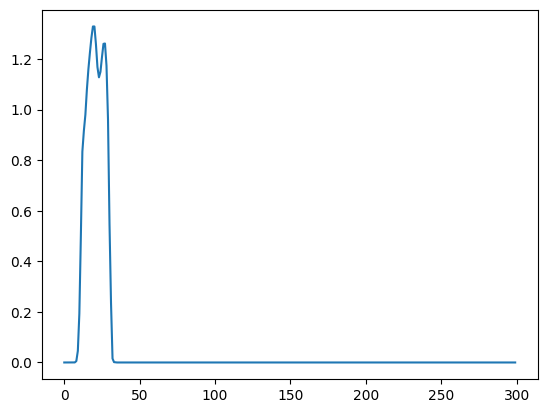

In [430]:
plt.plot(density_tensor[6,1,:])

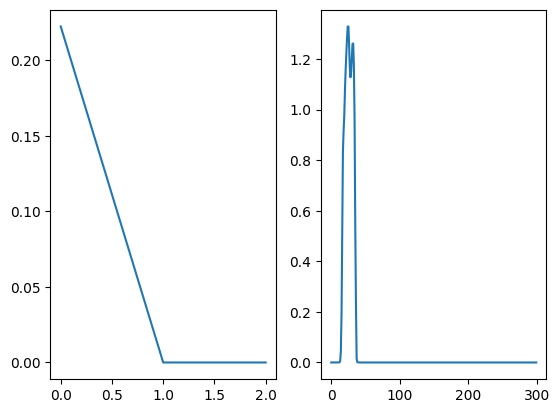

In [431]:
# import torch.nn as nn
my_test_layer = nn.AvgPool1d(100)
plt.subplot(121)
plt.plot(my_test_layer(density_tensor)[4,0,:])
plt.subplot(122)
plt.plot((density_tensor)[4,0,:])


In [311]:
# conv1d_layer = torch.nn.Conv1d(in_channels=2, out_channels =2 , kernel_size=9)
# source_tensor = torch.randn((9, 1))  # Assuming 1D output
# print(source_tensor.shape)
# print(len(density_tensor))

In [432]:
source_tensor

tensor([[10., 10.],
        [10., 10.],
        [10., 10.],
        ...,
        [90., 90.],
        [90., 90.],
        [90., 90.]])

In [451]:
# Assuming you have separate training and testing datasets
num_samples = len(density_tensor)
split_ratio = 0.8
split_index = int(split_ratio * num_samples)

In [452]:
train_density = density_tensor[:split_index]
test_density = density_tensor[split_index:]
train_source = source_tensor[:split_index]
test_source = source_tensor[split_index:]


In [453]:
train_source

tensor([[10., 10.],
        [10., 10.],
        [10., 10.],
        ...,
        [40., 40.],
        [40., 40.],
        [40., 40.]])

In [462]:
batch_size = 128

# Create DataLoader for training set
train_dataset = TensorDataset(train_density, train_source)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Create DataLoader for testing set
test_dataset = TensorDataset(test_density, test_source)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



In [480]:
# Define a simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self, debug=0):
        super(SimpleCNN, self).__init__()

        self.debug = debug
        
        self.conv1 = nn.Conv1d(in_channels=2, out_channels=4, kernel_size=3, stride=1, padding=1)

        self.relu1 = nn.ReLU()
    
        self.avgpool1 = nn.AvgPool1d(10)
        
        self.conv2 = nn.Conv1d(in_channels=4, out_channels=8, kernel_size=3, stride=1, padding=1)
    
        self.avgpool2 = nn.AvgPool1d(6)

        self.conv3 = nn.Conv1d(in_channels=8, out_channels=16, kernel_size=3, stride=2, padding=1)
       
        self.avgpool3 = nn.AvgPool1d(3)

        self.relu2 = nn.ReLU()

        self.conv4 = nn.Conv1d(in_channels=16, out_channels=16, kernel_size=3, stride=1, padding=1)

        self.relu3 = nn.ReLU()

        # Adjust the linear layer input size based on the number of output channels from the last convolutional layer
        # self.fc = nn.Linear(8, 16)
        
        self.flatten = nn.Flatten()
        self.linear_layer = nn.Linear(16, 1)

    def forward(self, x):
        # print("Size before reshaping:", x.size())
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.avgpool1(x)

        # print("Size before reshaping:", x.size())
        
        x = self.conv2(x)
        # x = self.relu2(x)
        x = self.avgpool2(x)

        # print("Size before reshaping:", x.size())
        x = self.conv3(x)
        x = self.avgpool3(x)
        x = self.relu2(x)

        # print("Size before reshaping:", x.size())
        x = self.conv4(x)
        x = self.relu3(x)

        # print("Size before flattening:", x.size())  # Add this line to check the size
        x = self.flatten(x)
        if self.debug:
            print(x.shape)
        x = self.linear_layer(x)

        # print("Size before reshaping:", x.size())
        return x
# at some p[oint we can switch to classification (equivalent to detetchgfgndfjkgh the room where the smoke is)

In [329]:
# def lr_lambda(epoch):
#     # LR to be 0.1 * (1/1+0.01*epoch)
#     base_lr = 0.1
#     factor = 0.001
#     return base_lr/(1+factor*epoch)

In [481]:
# Create an instance of the model
model = SimpleCNN(debug=0)
## List for loss
train_losses = []
test_losses = []

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Learning rate scheduler
# scheduler = optim.lr_scheduler.LambdaLR(optimizer,lr_lambda)  # Adjust step_size and gamma as needed


In [482]:
# Training loop
epochs = 100
for epoch in range(epochs):
    model.train()
    for density_batch, source_batch in train_loader:
        # # Forward pass
        # print(density_batch.shape)
        outputs = model(density_batch)

        # print(outputs.shape, source_batch.shape)

        # Compute loss
        loss = criterion(outputs, source_batch)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Learning rate scheduler step
    # scheduler.step()
    
    if epoch % 2 == 0:
        print(f'Epoch [{epoch}/{epochs}], Loss: {loss.item()}')

# Testing loop
    model.eval()
with torch.no_grad():
    for density_batch, source_batch in test_loader:
        test_outputs = model(density_batch)
        test_loss = criterion(test_outputs, source_batch)
        

# After training and testing, you can use the model to make predictions
predicted_sources = model(density_tensor)

Epoch [0/100], Loss: 2269.8798828125
Epoch [2/100], Loss: 1023.7583618164062
Epoch [4/100], Loss: 854.2447509765625
Epoch [6/100], Loss: 637.2994384765625
Epoch [8/100], Loss: 607.2345581054688
Epoch [10/100], Loss: 656.7335205078125
Epoch [12/100], Loss: 583.3344116210938
Epoch [14/100], Loss: 698.0215454101562
Epoch [16/100], Loss: 551.5860595703125
Epoch [18/100], Loss: 644.5272216796875
Epoch [20/100], Loss: 528.0069580078125
Epoch [22/100], Loss: 582.6764526367188
Epoch [24/100], Loss: 682.3333129882812
Epoch [26/100], Loss: 660.4523315429688
Epoch [28/100], Loss: 634.8528442382812
Epoch [30/100], Loss: 727.7540283203125
Epoch [32/100], Loss: 715.4033203125
Epoch [34/100], Loss: 677.223388671875
Epoch [36/100], Loss: 656.5161743164062
Epoch [38/100], Loss: 588.1859741210938
Epoch [40/100], Loss: 654.5703125
Epoch [42/100], Loss: 706.6381225585938
Epoch [44/100], Loss: 732.3369750976562
Epoch [46/100], Loss: 572.782470703125
Epoch [48/100], Loss: 659.4308471679688
Epoch [50/100], L

In [474]:
model.debug = 0

In [475]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
params

1333

In [476]:
source_batch

tensor([[90., 90.],
        [90., 90.],
        [90., 90.],
        [90., 90.],
        [90., 90.],
        [90., 90.],
        [90., 90.],
        [90., 90.],
        [90., 90.],
        [90., 90.],
        [90., 90.],
        [90., 90.],
        [90., 90.],
        [90., 90.],
        [90., 90.],
        [90., 90.],
        [90., 90.],
        [90., 90.],
        [90., 90.],
        [90., 90.],
        [90., 90.],
        [90., 90.],
        [90., 90.],
        [90., 90.],
        [90., 90.],
        [90., 90.],
        [90., 90.],
        [90., 90.],
        [90., 90.],
        [90., 90.],
        [90., 90.],
        [90., 90.],
        [90., 90.],
        [90., 90.]])